#Testing out VAE on basic shapes | Circles, rectangles, triangles

Autoencoder, generation of shapes, and information rate

a. Create a database of sufficient size of 28*28 images with circles, triangles and rectangles at random locations.

b. Create a suitable variational autoencoder (VAE) for the data in the database. Motivate the network configuration  (architecture, objective functions, hyperparameters) you select. 

c. Use your VAE to generate new dataand provide a quantitative measure of the performance of your system

d. Replace your VAE with a similar but not identical system that does not use the ELBO. Instead, control the distribution of the latent layer to be iid Gaussian (eg with MMD) and add Gaussian noise with a fixed that variance you set

e. Recalling that mutual information is given by $I(X;Y) = E[log\frac{p(X,Y)}{p(X)p(Y)}]$, estimate the information passing through the latent layer, in bits. Explain what this information represents in terms of your reconstruction. 

f. Compare the performance of the systems, using suitable attributes and/or extensions.

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

from keras import backend as K
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.utils import np_utils
#from keras.utils import to_categorical
from PIL import Image
import numpy as np
import os
import cv2
import random

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Shapes

In [2]:
# config values
NUM_OF_DATA = 1000

WIDTH = 28
HEIGHT = 28  #The above 3 will be used throughout

WHITE = (255,255,255)
BLACK = (0,0,0)

MIN_THICKNESS = 1
MAX_THICKNESS = 3
###

CENTER_X = WIDTH //2
CENTER_Y = HEIGHT//2

In [3]:
tri = []
for _ in range(NUM_OF_DATA):
    img = np.zeros((WIDTH, HEIGHT, 3), np.uint8) + 255

#triangles
    t_height = random.randint(HEIGHT//5, 4*HEIGHT//5)
    t_width  = random.randint(WIDTH //5, 4*WIDTH //5)
    t_dir    = random.randint(0,1) * 2 - 1
    #Random center
    x_bias = random.randint(t_width - WIDTH, WIDTH - t_width)//2
    y_bias = random.randint(t_height - HEIGHT, HEIGHT - t_height)//2

    t_thickness = random.randint(MIN_THICKNESS, MAX_THICKNESS)

    vertices = np.array([
        [CENTER_X + x_bias, CENTER_Y + t_height//2 * t_dir + y_bias],
        [CENTER_X - t_width//2 + x_bias, CENTER_Y - t_height//2 * t_dir + y_bias],
        [CENTER_X + t_width//2 + x_bias, CENTER_Y - t_height//2 * t_dir + y_bias]
    ])
    pts = vertices.reshape((-1, 1, 2))
    cv2.polylines(img, [pts], isClosed = True, color = BLACK, thickness = t_thickness)

    tri.append([img, (1,0,0)]) #label to indicate shape

temptri = img_to_array(tri[0][0])


In [4]:
rect = []
for _ in range(NUM_OF_DATA):
    img = np.zeros((WIDTH, HEIGHT, 3), np.uint8) + 255

#rectangles
    r_height = random.randint(HEIGHT//5, 4*HEIGHT//5)
    r_width  = random.randint(WIDTH //5, 4*WIDTH //5)

    #Random center
    x_bias = random.randint(r_width - WIDTH, WIDTH - r_width)//2
    y_bias = random.randint(r_height - HEIGHT, HEIGHT - r_height)//2

    r_thickness = random.randint(MIN_THICKNESS, MAX_THICKNESS)

    vertices = np.array([
        [CENTER_X + r_width//2 + x_bias, CENTER_Y + r_height//2 + y_bias],
        [CENTER_X - r_width//2 + x_bias, CENTER_Y + r_height//2 + y_bias],
        [CENTER_X - r_width//2 + x_bias, CENTER_Y - r_height//2 + y_bias],
        [CENTER_X + r_width//2 + x_bias, CENTER_Y - r_height//2 + y_bias]
    ])
    pts = vertices.reshape((-1, 1, 2))
    cv2.polylines(img, [pts], isClosed = True, color = BLACK, thickness = r_thickness)

    rect.append([img, (0,1,0)])

temprectangle = img_to_array(rect[0][0])

In [5]:
circ = []
for _ in range(NUM_OF_DATA):
    img = np.zeros((WIDTH, HEIGHT, 3), np.uint8) + 255

#circles
    c_rad = random.randint(max(WIDTH, HEIGHT) // 5, 2 * max(WIDTH, HEIGHT) // 5)

    c_thickness = random.randint(MIN_THICKNESS, MAX_THICKNESS)

    x_bias = random.randint(c_rad * 2 - WIDTH, WIDTH - c_rad * 2)//2
    y_bias = random.randint(c_rad * 2 - HEIGHT, HEIGHT - c_rad * 2)//2

    cv2.circle(img,
        center = (CENTER_X + x_bias, CENTER_Y + y_bias),
        radius = c_rad,
        color = BLACK,
        thickness = r_thickness
    )

    circ.append([img, (0,0,1)])

tempcircle = img_to_array(circ[0][0])

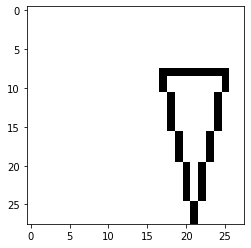

In [6]:
import matplotlib.pyplot as plt
plt.imshow(tri[3][0])

## Once again, we join the datasets and shuffle them

Rerun the cell below to create a new dataset

In [7]:
#tot_data = [(triangle for triangle in tri ),(circle for circle in circ), ( rectangle for rectangle in rect)]

#tot_data[0]
# import random
# random.shuffle(tot_data)
# for s in tot_data[:10]:
#   print(s)

tot_data = []
for t in tri: tot_data.append([cv2.cvtColor(t[0],cv2.COLOR_BGR2GRAY),t[1]])
for r in rect: tot_data.append([cv2.cvtColor(r[0],cv2.COLOR_BGR2GRAY),r[1]])
for c in circ: tot_data.append([cv2.cvtColor(c[0],cv2.COLOR_BGR2GRAY),c[1]])
random.shuffle(tot_data)
#tot_data[0]

data_x = []
data_y = []
for d in tot_data:
    data_x.append(d[0])
    data_y.append(d[1])

# xx = [data for data in tot_data[:][0]]
# #print(xx)
# #print(data_x[:10])
# #print(data_x[0], data_y[0])
# np.array(data_x).shape
# data_y

In [ ]:
number_of_classes = 3

In [ ]:
TRAIN = 1200
TEST = NUM_OF_DATA*3 - TRAIN
x = np.array(data_x[:TRAIN]).reshape(TRAIN, 28, 28, 1)
y = np.array(data_y[:TRAIN])+0.
xt = np.array(data_x[TRAIN:]).reshape(TEST, 28, 28, 1)
yt = np.array(data_y[TRAIN:])+0.
print(x.shape, y.shape)
print(xt.shape, yt.shape)

In [ ]:
import datetime
# rm -rf ./logs/

train_dataset = tf.data.Dataset.from_tensor_slices((x, y)) #x and y are training datasets to be defined beforehand
test_dataset = tf.data.Dataset.from_tensor_slices((xt, yt)) #xt and yt are test datasets to be defined beforehand

print(train_dataset)

Let us take a number of images from the dataset of images we have (essentially without the groundstruth labels), and run them through a VAE

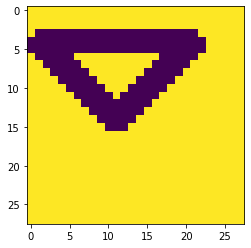

In [11]:
plt.imshow(data_x[2])   #Eg of one of our images

### Sample Code 2 | but with MNIST dataset | Sourced from bnsreenu on github in "python_for_microscopists/blob/master/178_179_variational_autoencoders_mnist"

An autoencoder takes input data (x), reduces its dimensionality in the encoder segment, determines its distinguishing features inside the bottleneck (the dimensions of which we have initially set to 2 below), and attempts to recreate the input ( or a denoised input) through the decoder (essentially expanding it back to its original dimensions).

Below is just how this would be done if we were using MNIST data, which we are not

In [12]:
# Load MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#Normalize and reshape ============

#Norm.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255

In [17]:
np.max(x_train)

1.0

In [18]:
np.max(data_x[1])

255

11501568/11490434 [==============================] - 0s 0us/step


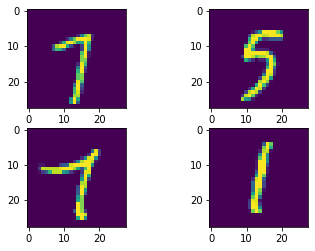

In [8]:


# Reshape 
img_width  = x_train.shape[1]
img_height = x_train.shape[2]
num_channels = 1 #MNIST --> grey scale so 1 channel
x_train = x_train.reshape(x_train.shape[0], img_height, img_width, num_channels)
x_test = x_test.reshape(x_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)
# ========================
#View a few images
plt.figure(1)
plt.subplot(221)
plt.imshow(x_train[42][:,:,0])

plt.subplot(222)
plt.imshow(x_train[420][:,:,0])

plt.subplot(223)
plt.imshow(x_train[4200][:,:,0])

plt.subplot(224)
plt.imshow(x_train[42000][:,:,0])
plt.show()

In [22]:
latent_dim = 2 # Number of latent dim parameters

input_img = Input(shape=input_shape, name='encoder_input')
x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

conv_shape = K.int_shape(x) #Shape of conv to be provided to decoder
#Flatten
x = Flatten()(x)
x = Dense(32, activation='relu')(x)

# Two outputs, for latent mean and log variance (std. dev.)
#Use these to sample random variables in latent space to which inputs are mapped. 
z_mu = Dense(latent_dim, name='latent_mu')(x)   #Mean values of encoded input
z_sigma = Dense(latent_dim, name='latent_sigma')(x)  #Std dev. (variance) of encoded input

#Combine the z layers mu and sigma to a sampling layer and outsource the sampling with epsilon | Reparameterization trick
def sample_z(args):
  z_mu, z_sigma = args
  eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
  return z_mu + K.exp(z_sigma / 2) * eps

z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_sigma])

# Define and summarize encoder model.
encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder')
print(encoder.summary())

# ================= ###########
# Decoder
#
# ================= #################

# decoder takes the latent vector as input
decoder_input = Input(shape=(latent_dim, ), name='decoder_input')

# Need to start with a shape that can be remapped to original image shape as
#we want our final utput to be same shape original input.
#So, add dense layer with dimensions that can be reshaped to desired output shape
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
# reshape to the shape of last conv. layer in the encoder, so we can 
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
# upscale (conv2D transpose) back to original shape
# use Conv2DTranspose to reverse the conv layers defined in the encoder
x = Conv2DTranspose(32, 3, padding='same', activation='relu',strides=(2, 2))(x)
#Can add more conv2DTranspose layers, if desired. 
#Using sigmoid activation
x = Conv2DTranspose(num_channels, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

# Define and summarize decoder model
decoder = Model(decoder_input, x, name='decoder')
decoder.summary()

# apply the decoder to the latent sample 
z_decoded = decoder(z)


# =========================
#Define custom loss
#VAE is trained using two loss functions reconstruction loss and KL divergence
#Let us add a class to define a custom layer with loss
class CustomLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        
        # Reconstruction loss (as we used sigmoid activation we can use binarycrossentropy)
        recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)
        return K.mean(recon_loss + kl_loss)

    # add custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomLayer()([input_img, z_decoded])
# y is basically the original image after encoding input img to mu, sigma, z
# and decoding sampled z values.
#This will be used as output for vae

# =================
# VAE 
# =================
vae = Model(input_img, y, name='vae')

# Compile VAE
vae.compile(optimizer='adam', loss=None)
vae.summary()

# Train autoencoder
vae.fit(x_train, None, epochs = 10, batch_size = 32, validation_split = 0.2)

# =================
# Visualize results
# =================
#Visualize inputs mapped to the Latent space
#Remember that we have encoded inputs to latent space dimension = 2. 
#Extract z_mu --> first parameter in the result of encoder prediction representing mean

mu, _, _ = encoder.predict(x_test)
#Plot dim1 and dim2 for mu
plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1], c=y_test, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()


# Visualize images
#Single decoded image with random input latent vector (of size 1x2)
#Latent space range is about -5 to 5 so pick random values within this range
#Try starting with -1, 1 and slowly go up to -1.5,1.5 and see how it morphs from 
#one image to the other.
sample_vector = np.array([[1,-1]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(img_width, img_height)
plt.imshow(decoded_example_reshaped)

#Let us automate this process by generating multiple images and plotting
#Use decoder to generate images by tweaking latent variables from the latent space
#Create a grid of defined size with zeros. 
#Take sample from some defined linear space. In this example range [-4, 4]
#Feed it to the decoder and update zeros in the figure with output.


n = 20  # generate 15x15 digits
figure = np.zeros((img_width * n, img_height * n, num_channels))

#Create a Grid of latent variables, to be provided as inputs to decoder.predict
#Creating vectors within range -5 to 5 as that seems to be the range in latent space
grid_x = np.linspace(-5, 5, n)
grid_y = np.linspace(-5, 5, n)[::-1]

# decoder for each square in the grid
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(img_width, img_height, num_channels)
        figure[i * img_width: (i + 1) * img_width,
               j * img_height: (j + 1) * img_height] = digit

plt.figure(figsize=(10, 10))
#Reshape for visualization
fig_shape = np.shape(figure)
figure = figure.reshape((fig_shape[0], fig_shape[1]))

plt.imshow(figure, cmap='gnuplot2')
plt.show()  

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 28, 28, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_5[0][0]                   
____________________________________________________________________________________________

TypeError: ignored